You are asked to answer each question by completing the code.
*   Please make sure that your code will work fine when the grader executes "Restart and run all"
*   Also make sure that your code won't output anything else but the result asked in the question

You can start with importing some useful libraries:

In [20]:
import numpy as np
import scipy.stats
from matplotlib import pyplot

#1. Secretary Problems

#1.1 Exponentially distributed item values

We consider a secretary problem where the item values (the performance of applicants) follow **exponential distribution** and there are $n$ items whose values will be revealed sequentially. More specifically, if $X_i$ is the random variable describing the $i$th item's value, then $X_i$'s are indepdent and exponentially distributed, i.e., they have the following cdf:
$$ \mathbb{P}(X_i \leq x) = 1-e^{-x}, \quad x \geq 0. $$
We can consider a simple threshold policy such that stops at the first item whose value is greater than $0.5$. Such a policy can be implemented as follow:

In [21]:
class ExampleAlgoExp:
  def initialize(self, num_items):
    self.n = num_items

  def action(self, i, value):
    if value > 0.5:
      return "select"
    return "skip"

We can simulate any policy using `simulate_exp()` function provided below.

*   The function takes three arguments. The first argument `algo` is expected to be the algorithm instance that implements two methods `initialize()` and `action()`. The second argument *num_items* is the number of items to be shown to the algorithm. The last argument `seed` is the seed value used for random number generation - this is useful to reproduce the result of random simulation.
*   The function returns the reward that the algorithm earns in a single run of simulation.
* This function works as follows. It first initializes the given algorithm, and randomly generates the item values (sampled from exponential distribution), and then sequentially shows the item values to the algorithm until the algorithm decides to *select*. It returns the value of selected item or zero if no item is selected by the algorithm.

We should be able to simulate any policy as long as it supports `initialize()` and `action()`.

In [22]:
def simulate_exp(algo, num_items, seed=0):
  algo.initialize( num_items )    # initialize the algorithm

  np.random.seed( seed=seed )
  item_values = scipy.stats.expon.rvs( size=num_items )   # randomly generate the item values
  for i,v in enumerate( item_values ):
    action = algo.action( i, v )              # retrieve the algorithm's decision
    assert( action in ("select", "skip") )    # the algorithm's action must be either "select" or "skip"
    if action == "select":
      return v
  return 0  # if the algorithm didn't select any item, it gets zero reward

The following code describes how to use `simulate()` function to evaluate the performance of the simple threshold policy when the number of items is 10. It performs 1,000 runs of simulation and reports the result averaged across 1,000 simulations.

In [31]:
num_items = 10
num_simulations = 1000
results = []
for s in range(num_simulations):
  reward = simulate_exp( ExampleAlgoExp(), num_items, s )
  results.append( reward )
print( "average performance of simple threshold policy = %f" % np.mean(results) )

average performance of simple threshold policy = 1.475611


**Your task is to implement the optimal algorithm (that maximizes the expected value of selected item) by completing `MyAlgoExp` class below**. As described above, your algorithm must implement `initialize()` and `action()` methods. In `initialize()`, you are expected to initialize the algorithm properly given the number of items, and in `action()`, you are expected to decide whether to select or skip to the $i$th item.

In [46]:
import math

class UCBSelector:
    def __init__(self, n_options):
        self.n_options = n_options
        self.counts = [0] * n_options
        self.values = [0.0] * n_options

    def select_option(self):
        ucb_values = [
            (self.values[i] + math.sqrt(2 * math.log(sum(self.counts) + 1) / (self.counts[i] + 1)))
            if self.counts[i] > 0 else float('inf')
            for i in range(self.n_options)
        ]
        return ucb_values.index(max(ucb_values))

    def select(self, value):
        selected_option = self.select_option()
        if value >= self.values[selected_option]:
            return 'select'
        else:
            return 'skip'

class MyAlgoExp:
  def initialize(self, num_items):
    self.ucb_selector = UCBSelector(num_items)
    pass

  def action(self, i, value):
    return  self.ucb_selector.select(value)

Your algorithm will be evaluated using the code below: **after implementing your own algorithm, please execute the following cell**

In [48]:
for n in [1, 5, 10, 20]:
  results = [ simulate_exp(MyAlgoExp(), n, s) for s in range(1000) ]
  print( "n = %d, average performance = %f" % (n, np.mean(results)) )

n = 1, average performance = 0.961663
n = 5, average performance = 0.961663
n = 10, average performance = 0.961663
n = 20, average performance = 0.961663


#1.2 Multiple-choice setting

We now consider a simple variant of secretary problem in which we can select more than one item. More specifically, the values of $n$ items are revealed sequentially and we need to decide whether to select each item right after is value is revealed, given that we can select at most $k$ items.

Similarly to above, we can consider a simple threshold policy:

In [8]:


class ExampleAlgoMulti:
  def initialize(self, num_items, num_choices):
    self.n = num_items
    self.k = num_choices

  def action(self, i, value):
    if value > 0.5:
      return "select"
    return "skip"

We can simulate any policy using `simulate_multi()` function:

In [9]:
def simulate_multi(algo, num_items, num_choices, seed=0):
  algo.initialize( num_items, num_choices )    # initialize the algorithm

  np.random.seed( seed=seed )
  item_values = scipy.stats.expon.rvs( size=num_items )   # randomly generate the item values
  remaining_num_choices = num_choices
  sum_selected_item_value = 0
  for i,v in enumerate( item_values ):
    action = algo.action( i, v )              # retrieve the algorithm's decision
    assert( action in ("select", "skip") )    # the algorithm's action must be either "select" or "skip"
    if action == "select":
      sum_selected_item_value += v
      remaining_num_choices -= 1
    if remaining_num_choices == 0:
      break
  return sum_selected_item_value              # if the algorithm didn't select any item, it gets zero reward

For example, the performance of simple threshold policy can be evaluated as follows:

In [27]:
num_items = 10
num_choices = 2
num_simulations = 1000
results = []
for s in range(num_simulations):
  reward = simulate_multi( ExampleAlgoMulti(), num_items, num_choices, s )
  results.append( reward )
print( "average performance of simple threshold policy = %f" % np.mean(results) )

average performance of simple threshold policy = 2.966887


**Your task is to implement optimal strategy (that maximizes the expected value of the sum of selected items' values) by completing `MyAlgoMulti` class below**.

In [63]:
import math

class UCBSelector:
    def __init__(self, n_options, num_choices):
        self.n_options = n_options
        self.counts = [0] * n_options
        self.values = [0.0] * n_options

    def select_option(self):
        ucb_values = [
            (self.values[i] + math.sqrt(2 * math.log(sum(self.counts) + 1) / (self.counts[i] + 1)))
            if self.counts[i] > 0 else float('inf')
            for i in range(self.n_options)
        ]
        return ucb_values.index(max(ucb_values))

    def select(self, value):
        selected_option = self.select_option()
        if value >= self.values[selected_option]:
            return "select"
        else:
            return "skip"

class MyAlgoExp:
  def initialize(self, num_items, num_choices):
    self.ucb_selector = UCBSelector(num_items, num_choices)

  def action(self, i, value):
    return self.ucb_selector.select(value)

Your algorithm will be evaluated using the code below: **after implementing your own algorithm, please execute the following cell**

In [64]:
for n in [1, 5, 10, 20]:
  for k in [1, 2, 5]:
    if k <= n:
      results = [ simulate_multi(MyAlgoMulti(), n, k, s) for s in range(100) ]
      print( "n = %d, k = %d, average performance = %f" % (n, k, np.mean(results)) )

AssertionError: 

#2. Optimal Betting Strategy

Let's imagine a betting game specified by three numbers $p$, $a$, and $b$
* $p \in [0,1]$ is the probability of winning
* $a \in [0,1]$ is the proportion of the bet lost with a lose.
* $b \in [0,\infty)$ is the proportion of the bet gained with a win.

For example, when betting \$10,
* if $a=1$, you lose all \$10 upon a negative outcome (lose).
* if $b=2$, you are returned \$30 (winning you \$20) upon a positive outcome (win).

You are expected to play this game $n$ times, starting with an initial wealth \$1,000. You need to decide the betting size at each round where you cannot bet more than you have. For example, the following code implements a simple policy that always bets half of the money the player owns:

In [13]:
class ExampleAlgoBetting:
  def initialize(self, p, a, b, num_rounds, initial_wealth):
    self.p, self.a, self.b = p, a, b

  def amount_to_bet(self, i, current_wealth):
    return 0.5 * current_wealth

  def feedback(self, i, outcome, net_change_in_wealth):
    pass

We can simulate any policy using `simulate_betting()` function implemented below:
* The first argument `algo` is expected to be an algorithm instance that should support `initialize()`, `amount_to_bet()`, and `feedback()` methods. The next arguments `p`, `a`, `b`, `num_rounds`, and `initial_wealth` specify the game information. The last argument `seed` specifies the random seed of a simulation.
* This function returns the time trajectory of player's wealth.

In [14]:
def simulate_betting(algo, p, a, b, num_rounds, initial_wealth, seed=0):
  algo.initialize( p, a, b, num_rounds, initial_wealth )    # initialize the algorithm

  current_wealth = initial_wealth
  wealth_trajectory = [ initial_wealth ]
  outcomes = scipy.stats.bernoulli.rvs( p, size=num_rounds )  # randomly generate (binary) outcomes of the games
  for i,outcome in enumerate(outcomes):
    betsize = algo.amount_to_bet(i, current_wealth )          # retrieve the algorithm's decision
    assert( 0 <= betsize <= current_wealth )                  # the betting size should be non-negative and smaller than the current_wealth
    if outcome == 0:
      result = -betsize*a                                     # if win, the player's wealth will decrease by betsize*a
    else:
      result = betsize*b                                      # if lose, the player's wealth will increase by betsize*a
    algo.feedback( i, outcome, result )                       # let the algorithm know about the result of the game
    current_wealth += result
    wealth_trajectory.append( current_wealth )

  return wealth_trajectory    # returns the trajectory of the player's wealth

Following code simulates the above simple betting strategy when $p = 0.8$ and $a=b=1$. It conducts 100 runs of simulation with 50 game plays and initial wealth \$1,000, and reports the average wealth at the end of 50 game plays as well as the average of log-wealth.

In [15]:
num_rounds = 50
num_simulations = 100
p, a, b = 0.7, 0.5, 0.5
initial_wealth = 1000

wealth_trajectories = np.zeros( shape=(num_simulations, num_rounds+1) )
for s in range(num_simulations):
  wealth_trajectories[s] = simulate_betting( ExampleAlgoBetting(), p, a, b, num_rounds, initial_wealth, s )

print( "average wealth after %d game plays = %f" % (num_rounds, np.mean(wealth_trajectories[:,-1])) )
print( "average log-wealth after %d game plays = %f" % (num_rounds, np.mean(np.log(wealth_trajectories[:,-1]))) )

average wealth after 50 game plays = 102702.956866
average log-wealth after 50 game plays = 10.341249


To better illustrate the simulation results, we can visualize the wealth trajectories using `matplotlib` module.

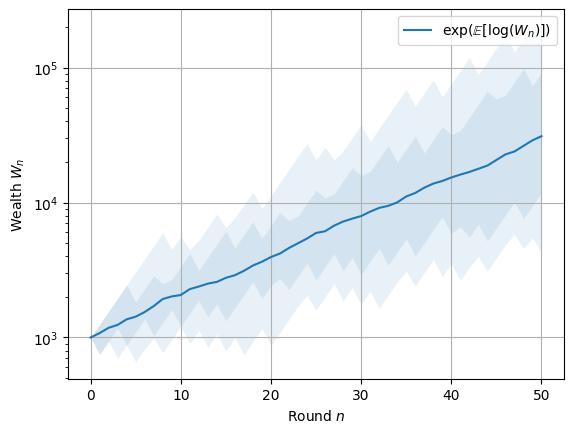

In [16]:
p = pyplot.plot( np.arange(num_rounds+1), np.exp( np.mean( np.log(wealth_trajectories), axis=0 ) ), label=r"$\exp(\mathbb{E}[\log(W_n)])$" )
pyplot.fill_between( np.arange(num_rounds+1), np.percentile( wealth_trajectories, 25, axis=0 ), np.percentile( wealth_trajectories, 75, axis=0 ), alpha=0.1, color=p[0].get_color(), linewidth=0 )
pyplot.fill_between( np.arange(num_rounds+1), np.percentile( wealth_trajectories, 10, axis=0 ), np.percentile( wealth_trajectories, 90, axis=0 ), alpha=0.1, color=p[0].get_color(), linewidth=0 )
pyplot.yscale( "log" )
pyplot.grid( True )
pyplot.xlabel( r"Round $n$" )
pyplot.ylabel( r"Wealth $W_n$" )
pyplot.legend( loc='best' )

**Your task is to implement the optimal betting strategy (that maximizes the expected log-wealth after $n$ game plays) by completing `MyAlgoBetting` class below**. As described above, your algorithm must implement `initialize()`, `amount_to_bet()`, and `feedback()` methods.
* In `initialize()`, you are expected to initialize the algorithm properly given the game information.
* In `amount_to_bet()`, you are expected to decide how much to bet in the $i$th game.
* In `feedback()`, you are expected to update state variables if you want. This is optional.

In [17]:
class MyAlgoBetting:
  def initialize(self, p, a, b, num_rounds, initial_wealth):
    # implement your code here
    pass

  def amount_to_bet(self, i, current_wealth):
    # implement your code here: this method should return the amount of money to bet
    return 0.5 * current_wealth

  def feedback(self, i, outcome, net_change_in_wealth):
    # (optional) implement your code here if you want to update the algorithm based on the result of previous game
    pass

Your algorithm will be evaluated using the code below: **after implementing your own algorithm, please execute the following two cells**.

In [18]:
num_rounds = 50
num_simulations = 100
initial_wealth = 1000

for p in [0.2, 0.5, 0.7]:
  for a,b in [ (1,1), (0.5,0.5), (0.5,4) ]:
    wealth_trajectories = np.zeros( shape=(num_simulations, num_rounds+1) )
    for s in range(num_simulations):
      wealth_trajectories[s] = simulate_betting( MyAlgoBetting(), p, a, b, num_rounds, initial_wealth, s )
    print( "p=%.1f, a=%.1f, b=%.1f, average performance = %f" % (p, a, b, np.mean(np.log(wealth_trajectories[:,-1])) ) )

p=0.2, a=1.0, b=1.0, average performance = -16.686578
p=0.2, a=0.5, b=0.5, average performance = -2.276143
p=0.2, a=0.5, b=4.0, average performance = 6.649991
p=0.5, a=1.0, b=1.0, average performance = -0.471061
p=0.5, a=0.5, b=0.5, average performance = 5.340267
p=0.5, a=0.5, b=4.0, average performance = 27.458270
p=0.7, a=1.0, b=1.0, average performance = 10.932535
p=0.7, a=0.5, b=0.5, average performance = 10.417873
p=0.7, a=0.5, b=4.0, average performance = 41.043954


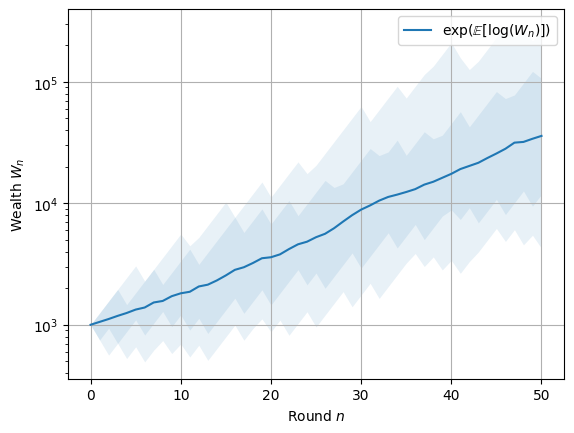

In [19]:
num_rounds = 50
num_simulations = 100
p, a, b = 0.7, 0.5, 0.5
initial_wealth = 1000

wealth_trajectories = np.zeros( shape=(num_simulations, num_rounds+1) )
for s in range(num_simulations):
  wealth_trajectories[s] = simulate_betting( MyAlgoBetting(), p, a, b, num_rounds, initial_wealth, s )

p = pyplot.plot( np.arange(num_rounds+1), np.exp( np.mean( np.log(wealth_trajectories), axis=0 ) ), label=r"$\exp(\mathbb{E}[\log(W_n)])$" )
pyplot.fill_between( np.arange(num_rounds+1), np.percentile( wealth_trajectories, 25, axis=0 ), np.percentile( wealth_trajectories, 75, axis=0 ), alpha=0.1, color=p[0].get_color(), linewidth=0 )
pyplot.fill_between( np.arange(num_rounds+1), np.percentile( wealth_trajectories, 10, axis=0 ), np.percentile( wealth_trajectories, 90, axis=0 ), alpha=0.1, color=p[0].get_color(), linewidth=0 )
pyplot.yscale( "log" )
pyplot.grid( True )
pyplot.xlabel( r"Round $n$" )
pyplot.ylabel( r"Wealth $W_n$" )
pyplot.legend( loc='best' )